In [1]:
import pickle

all_predictions_path = "/workspace/yolo_dataset_cls_5fold/predictions/all_predictions.pkl"

with open(all_predictions_path, "rb") as f:
    all_predictions = pickle.load(f)

print(all_predictions.keys())

dict_keys(['image_paths', 'pred_probs', 'labels', 'folds', 'class_names'])


In [2]:
all_predictions["image_paths"][0]

'/workspace/yolo_dataset_cls_5fold/fold_0/val/baseball_bat/dangerous_test_000010.jpg'

In [3]:
all_predictions["pred_probs"][0]

array([9.9800712e-01, 1.2560849e-04, 1.5967722e-04, 2.6172868e-04,
       6.6534747e-05, 1.3793666e-03], dtype=float32)

In [4]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from cleanlab.count import compute_confident_joint
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import re

PREDICTIONS_PATH = Path("/workspace/yolo_dataset_cls_5fold/predictions")
SOURCE_IMAGES_BASE = Path("/workspace/yolo_dataset_4_dec/images")
SOURCE_IMAGES_FOLDERS = ["train", "test", "valid"]
SOURCE_LABELS_PATH = Path("/workspace/yolo_dataset_4_dec/labels")
OUTPUT_BASE = Path("/workspace/convnext_label_errors")

with open(PREDICTIONS_PATH / "all_predictions.pkl", "rb") as f:
    all_predictions = pickle.load(f)

image_paths = all_predictions['image_paths']
pred_probs = np.array(all_predictions['pred_probs'])
labels = np.array(all_predictions['labels'])
class_names = all_predictions['class_names']

print(f"Total samples: {len(image_paths)}")
print(f"Pred probs shape: {pred_probs.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Classes: {class_names}")
print(f"\nLabel distribution:")
for i, name in enumerate(class_names):
    print(f"  {name}: {(labels == i).sum()}")

Total samples: 19874
Pred probs shape: (19874, 6)
Labels shape: (19874,)
Classes: ['baseball_bat', 'cell_phone', 'gun', 'human', 'knife', 'rifle']

Label distribution:
  baseball_bat: 1546
  cell_phone: 628
  gun: 6574
  human: 2984
  knife: 3404
  rifle: 4738


In [5]:
confident_joint, off_diag_indices = compute_confident_joint(
    labels=labels,
    pred_probs=pred_probs,
    calibrate=True,
    return_indices_of_off_diagonals=True
)

print("Confident Joint Matrix:")
print(confident_joint)
print(f"\nOff-diagonal examples (potential label errors): {len(off_diag_indices)}")


Confident Joint Matrix:
[[1543    0    0    1    2    0]
 [   0  625    0    2    0    1]
 [   1    0 6535    2    3   33]
 [   1    0    0 2983    0    0]
 [   4    1    2    0 3391    6]
 [   0    1   35    2    2 4698]]

Off-diagonal examples (potential label errors): 92


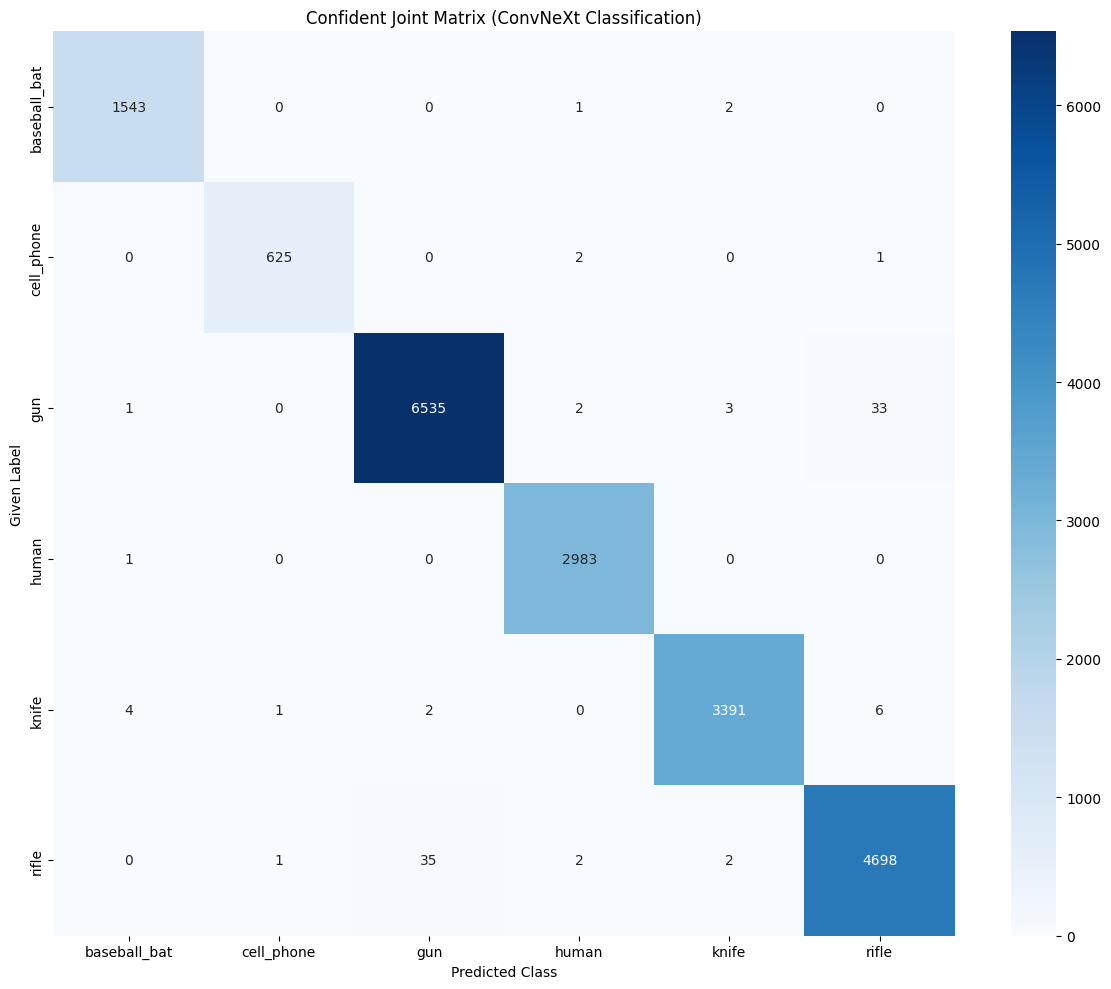

In [6]:
OUTPUT_BASE.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    confident_joint,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Class')
plt.ylabel('Given Label')
plt.title('Confident Joint Matrix (ConvNeXt Classification)')
plt.tight_layout()
plt.savefig(OUTPUT_BASE / 'confident_joint.png', dpi=150)
plt.show()


In [7]:
def get_base_image_name(crop_path):
    """Extract base image name from crop path, removing _crop{n} suffix if present."""
    stem = Path(crop_path).stem
    match = re.match(r'(.+)_crop\d+$', stem)
    if match:
        return match.group(1)
    return stem

def find_source_image(base_name, source_base_dir, folders):
    """Find the source image file with any extension across multiple folders."""
    for folder in folders:
        source_dir = source_base_dir / folder
        if not source_dir.exists():
            continue
        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            candidate = source_dir / f"{base_name}{ext}"
            if candidate.exists():
                return candidate
        for img_file in source_dir.glob(f"{base_name}.*"):
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                return img_file
    return None

error_candidates = []
for idx in off_diag_indices:
    given_label = labels[idx]
    pred_label = np.argmax(pred_probs[idx])
    pred_conf = pred_probs[idx][pred_label]
    given_conf = pred_probs[idx][given_label]
    
    crop_path = image_paths[idx]
    base_name = get_base_image_name(crop_path)
    
    error_candidates.append({
        'crop_path': crop_path,
        'base_image_name': base_name,
        'given_label': class_names[given_label],
        'predicted_label': class_names[pred_label],
        'predicted_conf': pred_conf,
        'given_label_conf': given_conf,
        'given_label_id': given_label,
        'predicted_label_id': pred_label
    })

errors_df = pd.DataFrame(error_candidates)
errors_df = errors_df.sort_values('predicted_conf', ascending=False)
print(f"Total potential label errors: {len(errors_df)}")
errors_df.head(20)


Total potential label errors: 92


,crop_path,base_image_name,given_label,predicted_label,predicted_conf,given_label_conf,given_label_id,predicted_label_id
67,/workspace/yolo_dataset_cls_5fold/fold_4/val/c...,hp_163,cell_phone,human,0.999952,0.000016,1,3
86,/workspace/yolo_dataset_cls_5fold/fold_4/val/r...,youtube_test_001725,rifle,gun,0.999846,0.000133,5,2
29,/workspace/yolo_dataset_cls_5fold/fold_1/val/r...,dangerous_train_002574,rifle,gun,0.999834,0.000125,5,2
5,/workspace/yolo_dataset_cls_5fold/fold_0/val/g...,youtube_train_009458,gun,rifle,0.999814,0.000159,2,5
60,/workspace/yolo_dataset_cls_5fold/fold_3/val/r...,dangerous_valid_000576,rifle,knife,0.999789,0.000028,5,4
76,/workspace/yolo_dataset_cls_5fold/fold_4/val/g...,youtube_train_009035,gun,rifle,0.999526,0.000442,2,5
73,/workspace/yolo_dataset_cls_5fold/fold_4/val/g...,voc_train_007833,gun,rifle,0.999329,0.000569,2,5
70,/workspace/yolo_dataset_cls_5fold/fold_4/val/g...,voc_test_001274,gun,human,0.999095,0.000827,2,3
68,/workspace/yolo_dataset_cls_5fold/fold_4/val/g...,dangerous_train_002894,gun,knife,0.998940,0.000637,2,4
89,/workspace/yolo_dataset_cls_5fold/fold_4/val/r...,youtube_train_008362,rifle,gun,0.998906,0.000892,5,2


In [8]:
errors_df.to_csv(OUTPUT_BASE / 'label_errors.csv', index=False)
np.save(OUTPUT_BASE / 'confident_joint.npy', confident_joint)

print(f"Saved: {OUTPUT_BASE / 'label_errors.csv'}")
print(f"Saved: {OUTPUT_BASE / 'confident_joint.npy'}")

print("\nError breakdown by type:")
breakdown = errors_df.groupby(['given_label', 'predicted_label']).size().sort_values(ascending=False)
print(breakdown)


Saved: /workspace/convnext_label_errors/label_errors.csv
Saved: /workspace/convnext_label_errors/confident_joint.npy

Error breakdown by type:
given_label   predicted_label
rifle         gun                31
gun           rifle              31
knife         rifle               5
              baseball_bat        4
gun           knife               3
rifle         knife               2
cell_phone    human               2
rifle         human               2
gun           human               2
baseball_bat  knife               2
knife         gun                 2
rifle         cell_phone          1
baseball_bat  human               1
knife         cell_phone          1
gun           baseball_bat        1
cell_phone    rifle               1
human         baseball_bat        1
dtype: int64


In [9]:
INSPECTION_PATH = OUTPUT_BASE / "inspection_by_error_type"
if INSPECTION_PATH.exists():
    shutil.rmtree(INSPECTION_PATH)
INSPECTION_PATH.mkdir(parents=True)

unique_base_images = errors_df['base_image_name'].unique()
print(f"Unique base images with errors: {len(unique_base_images)}")

copied_count = 0
not_found = []

for _, row in errors_df.iterrows():
    base_name = row['base_image_name']
    folder_name = f"labeled_{row['given_label']}_pred_{row['predicted_label']}"
    folder = INSPECTION_PATH / folder_name
    folder.mkdir(exist_ok=True)
    
    source_img = find_source_image(base_name, SOURCE_IMAGES_BASE, SOURCE_IMAGES_FOLDERS)
    
    if source_img and source_img.exists():
        dest_name = f"{base_name}_conf{row['predicted_conf']:.2f}{source_img.suffix}"
        dest_path = folder / dest_name
        if not dest_path.exists():
            shutil.copy2(source_img, dest_path)
            copied_count += 1
        
        for label_folder in ["train", "test", "valid"]:
            label_file = SOURCE_LABELS_PATH / label_folder / f"{base_name}.txt"
            if label_file.exists():
                dest_label = folder / f"{base_name}.txt"
                if not dest_label.exists():
                    shutil.copy2(label_file, dest_label)
                break
    else:
        if base_name not in not_found:
            not_found.append(base_name)

print(f"\nCopied {copied_count} images to: {INSPECTION_PATH}")
print(f"Images not found in source: {len(not_found)}")
if not_found[:5]:
    print(f"  Examples: {not_found[:5]}")

print("\nFolder contents:")
for folder in sorted(INSPECTION_PATH.iterdir()):
    if folder.is_dir():
        img_count = len(list(folder.glob('*.jpg'))) + len(list(folder.glob('*.png')))
        print(f"  {folder.name}: {img_count} images")

Unique base images with errors: 90

Copied 88 images to: /workspace/convnext_label_errors/inspection_by_error_type
Images not found in source: 3
  Examples: ['hp_163', 'hp_143', 'mp_94']

Folder contents:
  labeled_baseball_bat_pred_human: 1 images
  labeled_baseball_bat_pred_knife: 2 images
  labeled_cell_phone_pred_human: 0 images
  labeled_cell_phone_pred_rifle: 0 images
  labeled_gun_pred_baseball_bat: 1 images
  labeled_gun_pred_human: 2 images
  labeled_gun_pred_knife: 3 images
  labeled_gun_pred_rifle: 31 images
  labeled_human_pred_baseball_bat: 1 images
  labeled_knife_pred_baseball_bat: 4 images
  labeled_knife_pred_cell_phone: 1 images
  labeled_knife_pred_gun: 2 images
  labeled_knife_pred_rifle: 5 images
  labeled_rifle_pred_cell_phone: 1 images
  labeled_rifle_pred_gun: 30 images
  labeled_rifle_pred_human: 2 images
  labeled_rifle_pred_knife: 2 images


In [10]:
CROPS_PATH = OUTPUT_BASE / "inspection_crops"
if CROPS_PATH.exists():
    shutil.rmtree(CROPS_PATH)
CROPS_PATH.mkdir(parents=True)

crop_copied = 0
crop_not_found = []

for _, row in errors_df.iterrows():
    crop_path = Path(row['crop_path'])
    folder_name = f"labeled_{row['given_label']}_pred_{row['predicted_label']}"
    folder = CROPS_PATH / folder_name
    folder.mkdir(exist_ok=True)
    
    if crop_path.exists():
        dest_name = f"{crop_path.stem}_conf{row['predicted_conf']:.2f}{crop_path.suffix}"
        dest_path = folder / dest_name
        if not dest_path.exists():
            shutil.copy2(crop_path, dest_path)
            crop_copied += 1
    else:
        if str(crop_path) not in crop_not_found:
            crop_not_found.append(str(crop_path))

print(f"Copied {crop_copied} crop images to: {CROPS_PATH}")
print(f"Crops not found: {len(crop_not_found)}")

print("\nCrop folder contents:")
for folder in sorted(CROPS_PATH.iterdir()):
    if folder.is_dir():
        img_count = len(list(folder.glob('*.jpg'))) + len(list(folder.glob('*.png')))
        print(f"  {folder.name}: {img_count} images")


Copied 92 crop images to: /workspace/convnext_label_errors/inspection_crops
Crops not found: 0

Crop folder contents:
  labeled_baseball_bat_pred_human: 1 images
  labeled_baseball_bat_pred_knife: 2 images
  labeled_cell_phone_pred_human: 2 images
  labeled_cell_phone_pred_rifle: 1 images
  labeled_gun_pred_baseball_bat: 1 images
  labeled_gun_pred_human: 2 images
  labeled_gun_pred_knife: 3 images
  labeled_gun_pred_rifle: 31 images
  labeled_human_pred_baseball_bat: 1 images
  labeled_knife_pred_baseball_bat: 4 images
  labeled_knife_pred_cell_phone: 1 images
  labeled_knife_pred_gun: 2 images
  labeled_knife_pred_rifle: 5 images
  labeled_rifle_pred_cell_phone: 1 images
  labeled_rifle_pred_gun: 31 images
  labeled_rifle_pred_human: 2 images
  labeled_rifle_pred_knife: 2 images


In [ ]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\nOutput directory: {OUTPUT_BASE}")
print(f"\nFiles created:")
print(f"  - confident_joint.npy: Confident joint matrix")
print(f"  - confident_joint.png: Heatmap visualization")
print(f"  - label_errors.csv: All detected label errors ({len(errors_df)} rows)")
print(f"\nDirectories created:")
print(f"  - inspection_by_error_type/: Original images from {SOURCE_IMAGES_BASE} (train/test/valid)")
print(f"  - inspection_crops/: Crop images from classification dataset")
print(f"\nLabel error statistics:")
print(f"  Total potential errors: {len(errors_df)}")
print(f"  Unique base images affected: {len(errors_df['base_image_name'].unique())}")
print(f"\nTop 5 error types:")
for (given, pred), count in breakdown.head(5).items():
    print(f"  {given} -> {pred}: {count}")